In [1]:
import numpy as np
import more_itertools as mit

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

import scipy.stats as st

# The naive estimator that computes π/4 as the ratio of points within a circle of radius equal to 1 centered on (0, 0) to the total number of points drawn at random within a square of side length 2, also centered on (0, 0);

In [2]:
def generate(seed_x, seed_y):
    rng_x = np.random.default_rng(seed_x)
    rng_y = np.random.default_rng(seed_y)

    result = 0
    estimated_pi = 0.0
    expected_pi = 31415

    random_numbers_x, random_numbers_y, random_numbers = np.array([]), np.array([]), np.array([])

    while (int(estimated_pi * 10000) != expected_pi):
        random_number_x = (rng_x.random() * 2) - 1
        random_number_y = (rng_y.random() * 2) - 1

        random_number = (random_number_x ** 2) + (random_number_y ** 2) <= 1
        random_numbers = np.append(random_numbers, random_number)

        estimated_pi = np.mean(random_numbers) * 4
        
    return [len(random_numbers), estimated_pi]

In [3]:
seeds = mit.sieve(1_000_000)
next(seeds)

conf_interval = None
attempts_1 = []
estimations_1 = []

while (len(estimations_1) < 2 or conf_interval[1] - conf_interval[0] > 1e-4):
    seed_x, seed_y = next(seeds), next(seeds)
    attempt, estimation = generate(seed_x, seed_y)
    
    attempts_1.append(attempt)
    estimations_1.append(estimation)
    
    conf_interval = st.t.interval(0.95, len(estimations_1)-1, loc=np.mean(estimations_1), scale=st.sem(estimations_1))

/Users/shandydarma/.virtualenvs/hw_sape/lib/python3.11/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/shandydarma/.virtualenvs/hw_sape/lib/python3.11/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# The improved estimator seen in class that exploits conditioning and antithetic random numbers;

In [4]:
def generate_with_conditioning_antithetic(seed):
    rng = np.random.default_rng(seed)

    estimated_pi = 0.
    expected_pi = 3141
    uniforms = np.array([])

    while (int(estimated_pi * 1000) != expected_pi):
        u = rng.random()
        uniforms = np.append(uniforms, u)
        estimated_pi = np.mean((np.sqrt(1 - (uniforms ** 2)) + np.sqrt(1 - ((1 - uniforms) ** 2)))) * 2

    return (len(uniforms), estimated_pi)

In [5]:
seeds = mit.sieve(1_000_000)
next(seeds)

conf_interval = None
attempts_2 = []
estimations_2 = []

while (len(estimations_2) < 2 or conf_interval[1] - conf_interval[0] > 1e-4):
    seed = next(seeds)
    attempt, estimation = generate_with_conditioning_antithetic(seed)
    
    attempts_2.append(attempt)
    estimations_2.append(estimation)
    
    conf_interval = st.t.interval(0.95, len(estimations_2)-1, loc=np.mean(estimations_2), scale=st.sem(estimations_2))

# The improved estimator seen in class that exploits conditioning, antithetic random numbers, and stratification.

In [6]:
def generate_with_conditioning_antithetic_stratification(seed):
    rng = np.random.default_rng(seed)

    estimated_pi = 0.
    expected_pi = 31415
    uniforms = np.array([])

    while (int(estimated_pi * 10000) != expected_pi):
        u = rng.random()
        uniforms = np.append(uniforms, u)
        n = len(uniforms)
        j = np.arange(1, n+1)
        estimated_pi = np.mean(np.sqrt(1 - (((u + j - 1)/n) ** 2)) + np.sqrt(1 - ((j - u)/n) ** 2)) * 2

    return (len(uniforms), estimated_pi)

In [7]:
seeds = mit.sieve(1_000_000)

# for seed in seeds:
#     print(seed, generate_with_conditioning_antithetic_stratification(seed))

conf_interval = None
attempts_3 = []
estimations_3 = []

while (len(attempts_3) < 2 or conf_interval[1] - conf_interval[0] > 1e-4):
    seed = next(seeds)
    attempt, estimation = generate_with_conditioning_antithetic_stratification(seed)
    
    attempts_3.append(attempt)
    estimations_3.append(estimation)
    
    conf_interval = st.t.interval(0.95, len(estimations_3)-1, loc=np.mean(estimations_3), scale=st.sem(estimations_3))

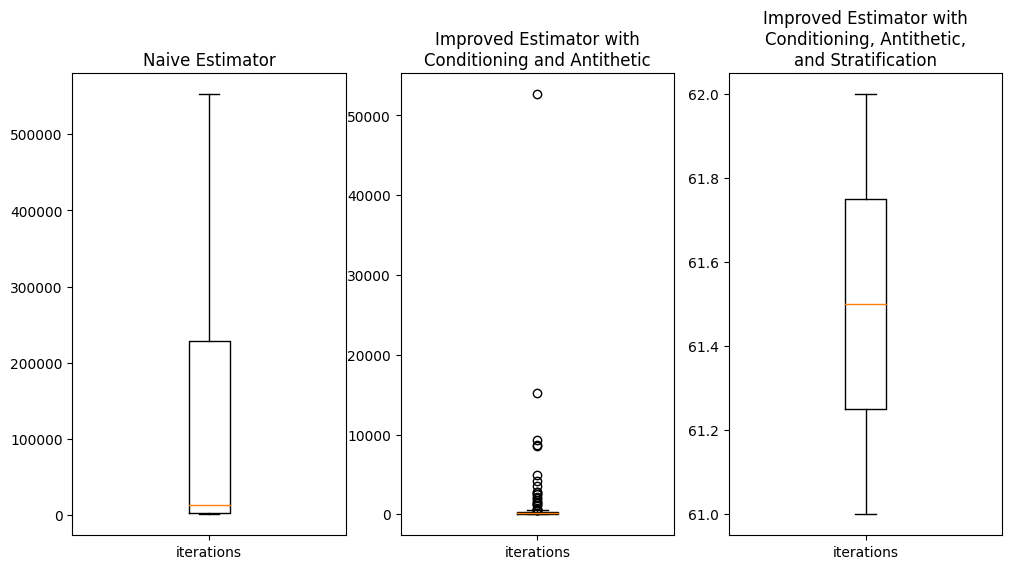

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12,6))
ax1.boxplot(attempts_1, labels=["iterations"])
ax1.title.set_text("Naive Estimator")
ax2.boxplot(attempts_2, labels=["iterations"])
ax2.title.set_text("Improved Estimator with\nConditioning and Antithetic")
ax3.boxplot(attempts_3, labels=["iterations"])
ax3.title.set_text("Improved Estimator with\nConditioning, Antithetic,\nand Stratification")